<a href="https://colab.research.google.com/github/electricshadok/notebooks/blob/main/CGAN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional-GAN : CIFAR-10

This notebook trains a Conditional GAN (cGAN) on CIFAR-10, generating images based on class labels.

- The **Generator** takes a random noise vector and a class label to generate an image.
- The **Discriminator** determines whether an image is real or fake while also verifying its class label.


The GAN is formulated as a min-max game between the Generator (G) and Discriminator (D):

$$\min_G \max_D V(D, G)$$

where the **value function** $V(D, G)$ is:

$$
V(D, G) = \mathbb{E}_{x \sim P_{\text{data}}} [\log D(x)] + \mathbb{E}_{z \sim P_{z}} [\log(1 - D(G(z)))]
$$

meaning

- The Discriminator's goal is to maximize $V(D, G)$ : D tries to maximize its ability to distinguish real images from fake ones.
- The Generator's goal is to minimize $V(D, G)$. G tries to minimize D ability to distinguish generated images from real ones.




**Architecture guidelines for stable Deep Convolutional GANs**

Based on this [paper](https://arxiv.org/pdf/1511.06434), here are some best practices for training a stable Deep Convolutional GAN (DCGAN):

- **No pooling layers** → Use strided convolutions in the discriminator and transposed convolutions in the generator for better learning.
- **Batch normalization** → Helps stabilize training in both generator and discriminator.
- **No fully connected layer**s → Deep architectures work better without them.
- **ReLU in the generator** → Used in all layers except the output, which uses Tanh for smooth image generation.
- **Leaky ReLU in the discriminator** → Helps with better gradient flow and prevents dead neurons.


**Features**

- ✅ Conditional GAN → Generate images based on class labels.
- ✅ Add Horizontal Flip → Improves diversity in training data.
- ✅ Use BCEWithLogitsLoss instead of BCE to avoid numerical instability.
- ⬜ Gradient Penalty → Prevents the Discriminator from becoming too strong, improving stability.
- ⬜ Spectral Normalization → Helps control gradients in the Discriminator, preventing instability.
- ⬜ Noise in Discriminator Input → Reduces overfitting and improves generalization (similar to label smoothing).
- ⬜ Learning Rate Decay → Keeps training stable over long epochs.
- ⬜ Feature Matching Loss → Helps the Generator produce more realistic images.
- ⬜ Concatenating Class Embeddings in G → Enhances control over generated images.
- ⬜ Add Metrics to Measure Results → Helps track GAN performance.

## Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

## Constants

In [ ]:
# input image embedding
NZ = 32
# class embedding
CZ = 16
# image size
IMAGE_SIZE = 32
# batch size
BATCH_SIZE = 32
# name of the classe to use from CIFAR10
# ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
CLASS_NAMES = ["airplane", "automobile"]
# number of classes
NUM_CLASSES = len(CLASS_NAMES)
# number of output channel
NC = 3

# Train Discriminator `n_disc` times per batch and Generator `n_gen` times
N_DISC = 2  # Train Discriminator more often (helps with stability)
N_GEN = 1   # Generator usually trained once per batch

# Global Activation Functions
ACTIVATION_FUNCTIONS = {
    "relu": nn.ReLU(True),
    "leaky_relu": nn.LeakyReLU(0.2, True),
    "tanh": nn.Tanh(),
    "sigmoid": nn.Sigmoid(),
    "none": nn.Identity()  # No activation
}

## Dataset

CIFAR-10 consists of 10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'].

A custom dataset class will return images, class labels.

In [ ]:
# Define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize((0.5,), (0.5,))
])

# Load full dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Select a subset of classes
selected_classes = set([dataset.classes.index(name) for name in CLASS_NAMES])
indices = [i for i, (_, label) in enumerate(dataset) if label in selected_classes]

# Create subset
dataset = Subset(dataset, indices)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Unnormalize helper function
def unnormalize(img: torch.Tensor) -> torch.Tensor:
    # Convert back to [0, 1] range for visualization
    return img.permute(1, 2, 0) * 0.5 + 0.5

100%|██████████| 170M/170M [00:12<00:00, 13.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


## Data Analysis and Visualization

Batch Mean -0.021604033187031746
Batch Std Dev 0.5212903618812561
Batch Min Pixel Value -1.0
Batch Max Pixel Value 1.0


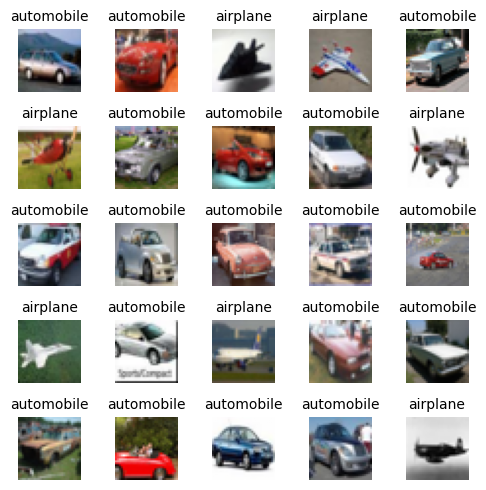

In [ ]:
def show_sample_images(dataset, num_rows=4, num_cols=4):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

    for i in range(num_rows * num_cols):
        img, label = dataset[i]
        img = unnormalize(img)
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(img)
        ax.set_title(CLASS_NAMES[label], fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Compute statistics
first_batch = next(iter(dataloader))
first_images, first_labels = first_batch  # Images: (batch_size, C, H, W), Labels: (batch_size,)
batch_mean = first_images.mean().item()
batch_std = first_images.std().item()
batch_min = first_images.min().item()
batch_max = first_images.max().item()


print("Batch Mean", batch_mean)
print("Batch Std Dev", batch_std)
print("Batch Min Pixel Value", batch_min)
print("Batch Max Pixel Value", batch_max)

# Example: Display a 5x5 grid of images
show_sample_images(dataset, num_rows=5, num_cols=5)

## Building Blocks

The key components of the model include upsampling, downsampling, and class embedding layers.

- **UpBlock** increases image resolution in the Generator using transposed convolutions.
- **DownBlock** reduces image size in the Discriminator using strided convolutions.
- **ClassEmbedding** converts class labels into learnable feature vectors, allowing the model to condition image generation on specific classes.

In [ ]:
class UpBlock(nn.Module):
    """
    Shapes:
        Input: (N, in_C, H, W)
        Output: (N, out_C, H*2, W*2)
    """
    def __init__(self, in_channels, out_channels, activation="relu", use_batchnorm=True):
        super().__init__()

        conv = nn.ConvTranspose2d(in_channels, out_channels,
                                  kernel_size=4, stride=2,
                                  padding=1, output_padding=0, bias=False)

        layers = [conv]
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(ACTIVATION_FUNCTIONS[activation])

        self.up = nn.Sequential(*layers)

    def forward(self, x):
        return self.up(x)


# Test UpBlock
x = torch.rand(BATCH_SIZE, NC * 2, IMAGE_SIZE, IMAGE_SIZE)
upblock = UpBlock(NC * 2, NC, "relu")
out_x = upblock(x)
print(f" UpBlock: in_shape:{list(x.shape)} out_shape: {list(out_x.shape)}")

 UpBlock: in_shape:[32, 6, 32, 32] out_shape: [32, 3, 64, 64]


In [ ]:
class DownBlock(nn.Module):
    """
    Shapes:
        Input: (N, in_C, H, W)
        Output: (N, out_C, H/2, W/2)
    """
    def __init__(self, in_channels, out_channels, activation="relu", use_batchnorm=True):
        super().__init__()
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)

        layers = [conv]
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(ACTIVATION_FUNCTIONS[activation])

        self.down = nn.Sequential(*layers)

    def forward(self, x):
        return self.down(x)

# Test DownBlock
x = torch.rand(BATCH_SIZE, NC, IMAGE_SIZE, IMAGE_SIZE)
down = DownBlock(NC, NC * 2, "relu")
out_x = down(x)
print(f" DownBlock: in_shape:{list(x.shape)} out_shape: {list(out_x.shape)}")

 DownBlock: in_shape:[32, 3, 32, 32] out_shape: [32, 6, 16, 16]


In [ ]:
class ClassEmbedding(nn.Module):
    """
    Shapes:
        Input: (N, )
        Output: (N, embedding_dim)
    """
    def __init__(self, num_classes, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, embedding_dim)

    def forward(self, labels):
        return self.embedding(labels)


# Test ClassEmbedding
labels = torch.randint(0, NUM_CLASSES, (BATCH_SIZE,))
label_emb = ClassEmbedding(NUM_CLASSES, CZ)
out_labels = label_emb(labels)
print(f" ClassEmbedding: in_shape:{list(labels.shape)} out_shape: {list(out_labels.shape)}")

 ClassEmbedding: in_shape:[32] out_shape: [32, 16]


## Generator

The **Generator** transforms a **random noise vector and a class label** into a structured image by progressively upsampling features.

In [ ]:
class Generator(nn.Module):
    """
    Shapes:
        Input: (N, image_embedding + class_embedding) and
        Output: (N, NC, IMAGE_SIZE, IMAGE_SIZE)
    """
    def __init__(self,
                 img_size=32,
                 num_classes = 10,
                 image_embedding = 100,
                 class_embedding=16,
                 filters = [32, 16, 8, 3],
                 activations = ["relu", "relu", "tanh"]):
        super().__init__()

        num_upsampling = len(filters) - 1

        self.label_emb = ClassEmbedding(num_classes, class_embedding)
        self.filters = filters
        self.init_size = img_size // 2 ** num_upsampling
        self.fc = nn.Linear(image_embedding + class_embedding,
                            filters[0] * self.init_size * self.init_size)

        self.batch_norm = nn.BatchNorm2d(filters[0])
        self.upsampling = nn.ModuleList()
        for i in range(num_upsampling):
            up_block = UpBlock(filters[i], filters[i+1], activation=activations[i])
            self.upsampling.append(up_block)


    def forward(self, noise, labels):
        # noise dimension for image (batch_size, image_embedding)
        # labels dimenson (batch_size, )
        # label embedding (batch_size, class_embedding)
        label_embedding = self.label_emb(labels)

        # Concatenate input labels and image_embedding + class_embedding
        z = torch.cat((noise, label_embedding), dim=1)
        batch_size = z.shape[0] # (batch_size, )

        out = self.fc(z) # (batch_size, init_features * init_size^2)
        out = out.view(batch_size, self.filters[0], self.init_size, self.init_size)

        out = self.batch_norm(out)
        for up in self.upsampling:
            out = up(out)

        return out

# Test Generator
img_emb = torch.rand(BATCH_SIZE, NZ)
class_emb = torch.randint(0, NUM_CLASSES, (BATCH_SIZE,))

gen = Generator(img_size = IMAGE_SIZE,
                num_classes = NUM_CLASSES,
                image_embedding = NZ,
                class_embedding = CZ,
                filters = [32, 16, 8, 3],
                activations = ["relu", "relu", "tanh"])


out_x = gen(img_emb, class_emb)
print(f" Generator: in_shape:{list(img_emb.shape)}+{list(class_emb.shape)} out_shape: {list(out_x.shape)}")

 Generator: in_shape:[32, 32]+[32] out_shape: [32, 3, 32, 32]


## Discriminator

The **Discriminator** evaluates whether an image is real or generated while considering its class label.

In [ ]:
class Discriminator(nn.Module):
    """
    Shapes:
        Input: (N, NC, IMAGE_SIZE, IMAGE_SIZE) + (N,)
        Output: (N, 1) (Probability of being real or fake)
    """
    def __init__(self,
                 img_size=32,
                 num_classes=10,
                 class_embedding=16,
                 filters = [3, 8, 16, 32],
                 activations = ["relu", "relu", "leaky_relu"]):
        super().__init__()

        num_downsampling = len(filters) - 1

        self.label_emb = ClassEmbedding(num_classes, class_embedding)
        self.filters = filters
        self.downsampling = nn.ModuleList()

        for i in range(num_downsampling):
            down_block = DownBlock(filters[i], filters[i+1], activations[i])
            self.downsampling.append(down_block)

        self.flatten_size = (img_size // (2 ** num_downsampling)) ** 2 * filters[-1]
        self.fc = nn.Linear(self.flatten_size + class_embedding, 1)
        # Note: No sigmoid since we using BCEWithLogitsLoss()
        #self.sigmoid = nn.Sigmoid()

    def forward(self, img, labels):
        """
        img: (batch_size, NC, IMAGE_SIZE, IMAGE_SIZE)
        labels: (batch_size,)
        """
        label_embedding = self.label_emb(labels)  # (batch_size, class_embedding)
        out = img

        for down in self.downsampling:
            out = down(out)

        out = out.view(out.size(0), -1) # Flatten the image features
        out = torch.cat((out, label_embedding), dim=1)  # Concatenate image features & label embedding

        out = self.fc(out)  # Fully connected layer
        #out = self.sigmoid(out)  # Sigmoid for real/fake probability

        return out


# Test Discriminator
disc = Discriminator(img_size = IMAGE_SIZE,
                     num_classes = NUM_CLASSES,
                     class_embedding = CZ,
                     filters = [3, 8, 16, 32],
                     activations = ["leaky_relu", "leaky_relu", "leaky_relu"])

img = torch.rand(BATCH_SIZE, NC, IMAGE_SIZE, IMAGE_SIZE)
class_emb = torch.randint(0, NUM_CLASSES, (BATCH_SIZE,))
out_x = disc(img, class_emb)
print(f" Discriminator: in_shape:{list(img.shape)}+{list(class_emb.shape)} out_shape: {list(out_x.shape)}")

 Discriminator: in_shape:[32, 3, 32, 32]+[32] out_shape: [32, 1]


## Training

The **Binary Cross-Entropy (BCE)** loss is used to measure how well the Discriminator classifies real and fake images.

$$L = - y \log(\hat{y}) - (1 - y) \log(1 - \hat{y})$$

where:
- $y$ is the **true label** (1 for real, 0 for fake).
- $\hat{y}$ is the **predicted probability** from the Discriminator.

For GAN training, we use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) instead of **BCE** to avoid numerical instability.

During training, both **Generator (G) and Discriminator (D)** losses should stay within a stable range:

- **D Loss** should be between **0.5 - 1.5**
- **G Loss** should be between **0.5 - 2.0**
- Losses will fluctuate but should remain relatively stable over time


If **D or G loss becomes extreme**, it indicates instability in training. This can lead to mode collapse (G produces the same image repeatedly) or discriminator overpowering (D always wins, preventing G from improving).

The paper **"Generative Adversarial Nets"** ([Goodfellow et al., 2014](https://arxiv.org/pdf/1406.2661)) derives the optimal discriminator loss at equilibrium.

At **optimality**, the Discriminator outputs:

$$D^*(x) = \frac{P_{\text{data}}(x)}{P_{\text{data}}(x) + P_{\text{gen}}(x)}$$

where:

- $P_{\text{data}}(x)$ is the probability density of real data.

- $P_{\text{gen}}(x)$ is the probability density of generated data.

At equilibrium, **the Discriminator cannot perfectly distinguish between real and fake images,** meaning it outputs **0.5 on average.**

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 50
BATCH_SIZE = 64
NUM_TEST_BATCHES = None # None for full training

# Initialize models
gen = Generator(img_size = IMAGE_SIZE,
                num_classes = NUM_CLASSES,
                image_embedding = NZ,
                class_embedding = CZ,
                filters = [32, 16, 8, 3],
                activations = ["relu", "relu", "tanh"])
gen.to(DEVICE)

disc = Discriminator(img_size = IMAGE_SIZE,
                     num_classes = NUM_CLASSES,
                     class_embedding = CZ,
                     filters = [3, 8, 16, 32],
                     activations = ["leaky_relu", "leaky_relu", "leaky_relu"])
disc.to(DEVICE)

# Define loss and optimizers
loss = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load CIFAR-10 Dataset
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Training Loop
for epoch in range(EPOCHS):
    for i, (real_images, labels) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images, labels = real_images.to(DEVICE), labels.to(DEVICE)

        if NUM_TEST_BATCHES is not None and i >= NUM_TEST_BATCHES:
            break # Stop early if limited batch mode is enabled

        # Create real and fake labels
        # Option 1: Below default laberl
        # real_labels = torch.ones(batch_size, 1).to(DEVICE)
        # fake_labels = torch.zeros(batch_size, 1).to(DEVICE)
        # Option 2 : Label smoothing mentioned in "Improved Techniques for Training GANs"
        real_labels = torch.full((batch_size, 1), 0.9, device=DEVICE)
        fake_labels = torch.full((batch_size, 1), 0.1, device=DEVICE)

        # --------------------
        # Train Discriminator
        # --------------------
        for _ in range(N_DISC):
            optimizer_D.zero_grad()

            # Compute loss on real images
            real_preds = disc(real_images, labels)
            real_loss = loss(real_preds, real_labels)

            # Generate fake images
            noise = torch.randn(batch_size, NZ, device=DEVICE)
            fake_images = gen(noise, labels)

            # Compute loss on fake images
            fake_preds = disc(fake_images.detach(), labels) # `detach()` prevents generator updates here
            fake_loss = loss(fake_preds, fake_labels)

            # Total Discriminator loss
            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

        # ---------------------
        # Train Generator
        # --------------------
        for _ in range(N_GEN):
            optimizer_G.zero_grad()

            # Generate fake images
            noise = torch.randn(batch_size, NZ, device=DEVICE)
            fake_images = gen(noise, labels)

            # Generator wants to trick Discriminator
            gen_preds = disc(fake_images, labels)
            g_loss = loss(gen_preds, real_labels)  # Wants to be classified as real

            g_loss.backward()
            optimizer_G.step()

        if i % 500 == 0:
            print(f"Epoch [{epoch}/{EPOCHS}] Batch {i}/{len(dataloader)} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

Epoch [0/50] Batch 0/157 | D Loss: 1.3770 | G Loss: 0.7264
Epoch [1/50] Batch 0/157 | D Loss: 0.6973 | G Loss: 1.8226
Epoch [2/50] Batch 0/157 | D Loss: 0.7098 | G Loss: 1.7153
Epoch [3/50] Batch 0/157 | D Loss: 0.6744 | G Loss: 2.0117
Epoch [4/50] Batch 0/157 | D Loss: 0.6749 | G Loss: 2.0665
Epoch [5/50] Batch 0/157 | D Loss: 0.6711 | G Loss: 2.0963
Epoch [6/50] Batch 0/157 | D Loss: 0.6721 | G Loss: 2.1464
Epoch [7/50] Batch 0/157 | D Loss: 0.6664 | G Loss: 2.0526
Epoch [8/50] Batch 0/157 | D Loss: 0.6836 | G Loss: 2.7192
Epoch [9/50] Batch 0/157 | D Loss: 0.6650 | G Loss: 2.0916
Epoch [10/50] Batch 0/157 | D Loss: 0.6578 | G Loss: 2.1339
Epoch [11/50] Batch 0/157 | D Loss: 0.6634 | G Loss: 2.1333
Epoch [12/50] Batch 0/157 | D Loss: 0.6613 | G Loss: 2.0846
Epoch [13/50] Batch 0/157 | D Loss: 0.6660 | G Loss: 2.2441
Epoch [14/50] Batch 0/157 | D Loss: 0.6837 | G Loss: 2.5654
Epoch [15/50] Batch 0/157 | D Loss: 0.6673 | G Loss: 2.0836
Epoch [16/50] Batch 0/157 | D Loss: 0.6958 | G Los

## Generation & Evaluation

Generates images with the trained model

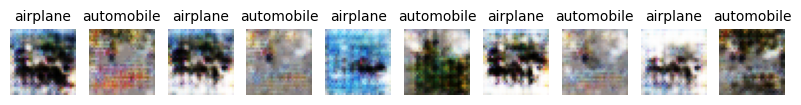

In [ ]:
NUM_IMAGES = 10
torch.manual_seed(20)
noise = torch.randn(NUM_IMAGES, NZ, device=DEVICE)
labels = torch.arange(0, NUM_IMAGES, device=DEVICE) % NUM_CLASSES
images = gen(noise, labels).cpu().detach()

# TODO : compute the probability for each generated image

fig, ax = plt.subplots(1, 10, figsize=(10, 2))
for j in range(NUM_IMAGES):
    img = images[j].permute(1, 2, 0) * 0.5 + 0.5  # Normalize to [0,1]
    ax[j].imshow(img)
    ax[j].axis("off")
    ax[j].set_title(CLASS_NAMES[labels[j]], fontsize=10)

plt.show()

## Resources

- [Training a Conditional DC-GAN on CIFAR-10](https://medium.com/@utk.is.here/training-a-conditional-dc-gan-on-cifar-10-fce88395d610)  
- [Conditional Generative Adversarial Nets (Mirza & Osindero, 2014)](https://arxiv.org/abs/1411.1784)  
- [Improved Techniques for Training GANs (Salimans et al., 2016)](https://arxiv.org/abs/1606.03498)  
- [Wasserstein GAN (Arjovsky et al., 2017)](https://arxiv.org/abs/1701.07875)  
- [Fast.ai Course – Diffusion Models (Lesson 21)](https://course.fast.ai/Lessons/lesson21.html)  
- [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)  
- [GAN Guide – Practical Resources](https://github.com/garridoq/gan-guide/tree/master)  
- [DCGAN CIFAR-10 PyTorch Implementation](https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch/blob/master/gan_cifar.py)  